In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


## importing and renaming the country column of the hotels and users 

In [2]:
hotels=pd.read_csv("C:\\Users\\abdel\\ACL\\archive\\hotels.csv")
reviews=pd.read_csv("C:\\Users\\abdel\\ACL\\archive\\reviews.csv")
users=pd.read_csv("C:\\Users\\abdel\\ACL\\archive\\users.csv")
hotels = hotels.rename(columns={'country': 'hotel_country'})
users = users.rename(columns={'country': 'user_country'})


# Merging

In [ ]:
review_hotel_df=reviews.merge(hotels,on='hotel_id',how='left')
df=review_hotel_df.merge(users,on='user_id',how='left')
df.to_csv("model2_merged.csv",index=False)

In [4]:
df.head()

,review_id,user_id,hotel_id,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,...,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,user_gender,user_country,age_group,traveller_type,join_date
0,1,1600,1,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,...,8.8,8.9,9.5,8.6,8.0,Female,New Zealand,25-34,Solo,2021-03-21
1,2,432,4,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,...,9.0,9.3,8.5,9.5,8.2,Female,United Kingdom,35-44,Couple,2025-04-01
2,3,186,18,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,...,8.7,8.6,9.1,8.7,8.4,Female,Spain,55+,Couple,2021-10-28
3,4,1403,19,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,...,9.1,8.9,9.7,9.0,8.8,Female,United Kingdom,35-44,Business,2023-10-10
4,5,1723,17,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,...,9.3,9.0,9.0,9.1,8.6,Male,Australia,45-54,Family,2023-02-28


# Dropping unnecesary columns 

In [18]:
columns_to_drop = [
    'review_id',       
    'user_id',        
    'hotel_id',      
    'hotel_name',    
    'city',           
    'user_country',    
    'lat',   
    'review_text',       
    'lon'      
]

try:
    
    df_cleaned = df.drop(columns=columns_to_drop)
    print("Successfully dropped columns.")
    print("Remaining columns:", df_cleaned.columns.to_list())

except KeyError as e:
    print(f"Error dropping column: {e}")
    print("Please make sure all column names in the 'columns_to_drop' list exist in your DataFrame.")

Successfully dropped columns.
Remaining columns: ['review_date', 'score_overall', 'score_cleanliness', 'score_comfort', 'score_facilities', 'score_location', 'score_staff', 'score_value_for_money', 'hotel_country', 'star_rating', 'cleanliness_base', 'comfort_base', 'facilities_base', 'location_base', 'staff_base', 'value_for_money_base', 'user_gender', 'age_group', 'traveller_type', 'join_date']


In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_date            50000 non-null  object 
 1   score_overall          50000 non-null  float64
 2   score_cleanliness      50000 non-null  float64
 3   score_comfort          50000 non-null  float64
 4   score_facilities       50000 non-null  float64
 5   score_location         50000 non-null  float64
 6   score_staff            50000 non-null  float64
 7   score_value_for_money  50000 non-null  float64
 8   country                50000 non-null  object 
 9   star_rating            50000 non-null  int64  
 10  cleanliness_base       50000 non-null  float64
 11  comfort_base           50000 non-null  float64
 12  facilities_base        50000 non-null  float64
 13  location_base          50000 non-null  float64
 14  staff_base             50000 non-null  float64
 15  va

In [ ]:

groups={'North_America':['United States','Canada'],
        'Western_Europe':['Germany','France','United Kingdom','Netherlands','Spain','Italy'],
        'Eastern_Europe':['Russia'],
        'East_Asia':['China','Japan','South Korea'],
        'Southeast_Asia':['Thailand','Singapore'],
        'Middle_East':['United Arab Emirates','Turkey'],
        'Africa':['Egypt','Nigeria','South Africa'],
        'Oceania':['Australia','New Zealand'],
        'South_America':['Brazil','Argentina'],
        'South_Asia':['India'],
        'North_America_Mexico':['Mexico']}

df_cleaned["country_group"]=df_cleaned["hotel_country"].apply(lambda x: next((key for key, value in groups.items() if x in value), "Other"))

# 3. IMPORTANT: Check if any countries were not mapped
missing_countries = df_cleaned[df_cleaned['country_group'] == "Other"]['hotel_country'].unique()
if len(missing_countries) > 0:
    print(f"Warning: The following countries were found but not in the map: {missing_countries}")
else:
    print("Successfully created 'country_group' column with no missing values.")

df_engineered = df_cleaned.drop(columns=['hotel_country'])

print("\n'country_group' column created and 'hotel_country' column dropped.")

Successfully created 'country_group' column with no missing values.

'country_group' column created and 'country' column dropped.


In [16]:
df_engineered.head()


,review_date,score_overall,score_cleanliness,score_comfort,score_facilities,score_location,score_staff,score_value_for_money,star_rating,cleanliness_base,comfort_base,facilities_base,location_base,staff_base,value_for_money_base,user_gender,age_group,traveller_type,join_date,country_group
0,2022-10-07,8.7,8.6,8.7,8.5,9.0,8.8,8.7,5,9.1,8.8,8.9,9.5,8.6,8.0,Female,25-34,Solo,2021-03-21,North_America
1,2020-03-24,9.1,10.0,9.1,9.0,8.6,9.4,8.6,5,9.6,9.0,9.3,8.5,9.5,8.2,Female,35-44,Couple,2025-04-01,East_Asia
2,2023-12-18,8.8,9.7,8.8,8.3,8.7,8.1,8.6,5,8.8,8.7,8.6,9.1,8.7,8.4,Female,55+,Couple,2021-10-28,Africa
3,2022-06-22,8.9,9.0,8.8,8.5,9.6,9.1,8.3,5,9.2,9.1,8.9,9.7,9.0,8.8,Female,35-44,Business,2023-10-10,Western_Europe
4,2022-07-02,9.1,8.9,9.5,9.3,8.3,9.4,8.9,5,9.1,9.3,9.0,9.0,9.1,8.6,Male,45-54,Family,2023-02-28,Eastern_Europe


In [ ]:

df_engineered['diff_cleanliness'] = df_engineered['score_cleanliness'] - df_engineered['cleanliness_base']
df_engineered['diff_comfort'] = df_engineered['score_comfort'] - df_engineered['comfort_base']
df_engineered['diff_facilities'] = df_engineered['score_facilities'] - df_engineered['facilities_base']
df_engineered['diff_overall_vs_star'] = df_engineered['score_overall'] - df_engineered['star_rating']
df_engineered['diff_location'] = df_engineered['score_location'] - df_engineered['location_base']
df_engineered['diff_staff'] = df_engineered['score_staff'] - df_engineered['staff_base']
df_engineered['diff_value_for_money'] = df_engineered['score_value_for_money'] - df_engineered['value_for_money_base']

print("Successfully created all 'diff' features. ✅")
print("\nHead of the new 'diff' features:")
print(df_engineered[[ 'diff_cleanliness', 'diff_comfort', 'diff_facilities','diff_overall_vs_star', 'diff_location', 'diff_staff', 'diff_value_for_money']].head())

Successfully created all 'diff' features. ✅

Head of the new 'diff' features:
   diff_cleanliness  diff_comfort  diff_facilities  diff_overall_vs_star  \
0              -0.5          -0.1             -0.4                   3.7   
1               0.4           0.1             -0.3                   4.1   
2               0.9           0.1             -0.3                   3.8   
3              -0.2          -0.3             -0.4                   3.9   
4              -0.2           0.2              0.3                   4.1   

   diff_location  diff_staff  diff_value_for_money  
0           -0.5         0.2                   0.7  
1            0.1        -0.1                   0.4  
2           -0.4        -0.6                   0.2  
3           -0.1         0.1                  -0.5  
4           -0.7         0.3                   0.3  


In [10]:
df_engineered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_date            50000 non-null  object 
 1   score_overall          50000 non-null  float64
 2   score_cleanliness      50000 non-null  float64
 3   score_comfort          50000 non-null  float64
 4   score_facilities       50000 non-null  float64
 5   score_location         50000 non-null  float64
 6   score_staff            50000 non-null  float64
 7   score_value_for_money  50000 non-null  float64
 8   star_rating            50000 non-null  int64  
 9   cleanliness_base       50000 non-null  float64
 10  comfort_base           50000 non-null  float64
 11  facilities_base        50000 non-null  float64
 12  location_base          50000 non-null  float64
 13  staff_base             50000 non-null  float64
 14  value_for_money_base   50000 non-null  float64
 15  us

In [ ]:
# features about the user 
categorical_features = [
    'user_gender', 
    'age_group', 
    'traveller_type'
]
# score based and quality based features 
numerical_features = [
    'diff_cleanliness', 
    'diff_comfort', 
    'diff_facilities', 
    'diff_overall_vs_star',
    'diff_location', 
    'diff_staff', 
    'diff_value_for_money'
]

# Create your final features matrix (X)
X = df_engineered[categorical_features + numerical_features]

y = df_engineered['country_group']

print(f"Original X shape: {X.shape} | Original y shape: {y.shape}")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     
    random_state=42,   
    stratify=y
)

print(f"X_train shape: {X_train.shape} | X_test shape: {X_test.shape}")

# ----------------------------------------------------------------------
# 3. Build the PREPROCESSING Pipeline
# ----------------------------------------------------------------------
# This is where the encoding and scaling happen.
# We define *what* to do, and the ColumnTransformer does it.

# Create a transformer for numerical features:
# It will scale them (e.g., StandarldScaler).
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create a transformer for categorical features:
# It will one-hot encode them.
# handle_unknown='ignore' prevents errors if a rare category
# appears in the test set but not the train set.
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Use ColumnTransformer to apply the right transformations to the right columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep any other columns (though we don't have any)
)

# ----------------------------------------------------------------------
# 4. Create and Train the Full Model Pipeline
# ----------------------------------------------------------------------
# We chain the preprocessor and the classifier in one final pipeline.
# This is the "complete" model.

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        max_iter=1000,      # Increase iterations for convergence
        random_state=42
    ))
])

# Train the entire pipeline on the training data
# When we call .fit(), it automatically does this:
# 1. Fits the preprocessor on X_train
# 2. Transforms X_train
# 3. Fits the classifier on the transformed X_train
print("\nStarting model training...")
model_pipeline.fit(X_train, y_train)
print("Model training complete. ✅")

# ----------------------------------------------------------------------
# 5. Evaluate the Model
# ----------------------------------------------------------------------
# When we call .score() or .predict(), it automatically:
# 1. Transforms X_test using the *already-fitted* preprocessor
# 2. Makes predictions using the trained classifier

accuracy = model_pipeline.score(X_test, y_test)
print(f"\nModel Accuracy on Test Set: {accuracy * 100:.2f}%")

# You can also get other metrics
y_pred = model_pipeline.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Original X shape: (50000, 10) | Original y shape: (50000,)
X_train shape: (40000, 10) | X_test shape: (10000, 10)

Starting model training...
Model training complete. ✅

Model Accuracy on Test Set: 31.87%

Classification Report:
                      precision    recall  f1-score   support

              Africa       0.29      0.61      0.40      1226
           East_Asia       0.30      0.27      0.28      1216
      Eastern_Europe       0.00      0.00      0.00       394
         Middle_East       0.00      0.00      0.00       797
       North_America       0.10      0.04      0.05       792
North_America_Mexico       0.02      0.00      0.01       401
             Oceania       0.00      0.00      0.00       803
       South_America       0.42      0.18      0.26       784
          South_Asia       0.00      0.00      0.00       398
      Southeast_Asia       0.23      0.02      0.04       814
      Western_Europe       0.34      0.81      0.48      2375

            accuracy     

c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\abdel\fire_env_tf\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
X = final_df[['diff_overall_vs_star','diff_cleanliness','diff_comfort','diff_facilities','diff_location','diff_staff','diff_value_for_money','traveller_type_Couple','traveller_type_Family','traveller_type_Solo',"user_country_Australia","user_country_Brazil","user_country_Canada","user_country_China","user_country_Egypt","user_country_France","user_country_Germany","user_country_India","user_country_Italy","user_country_Japan","user_country_Mexico","user_country_Netherlands","user_country_New Zealand","user_country_Nigeria","user_country_Russia","user_country_Singapore","user_country_South Africa","user_country_South Korea","user_country_Spain","user_country_Thailand","user_country_Turkey","user_country_United Arab Emirates","user_country_United Kingdom","user_country_United States", 'user_gender_Male','user_gender_Other','age' ]] 
y = final_df['country_group']

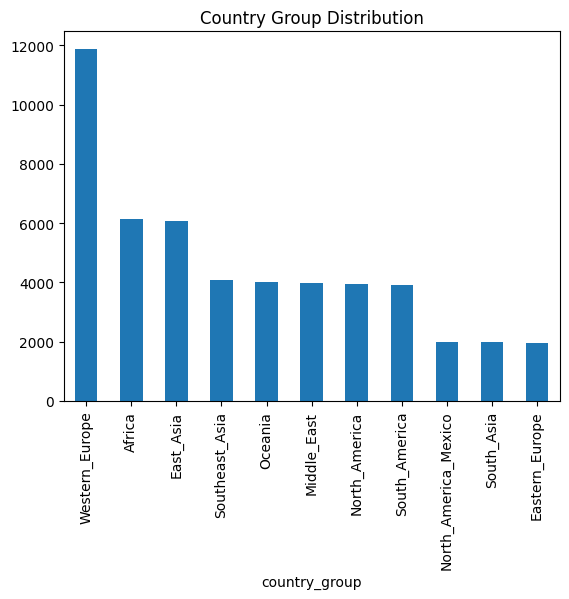

In [30]:
y.value_counts().plot(kind='bar', title='Country Group Distribution')
plt.show()

In [32]:


# Note: You may need to install TensorFlow if you haven't already:
# pip install tensorflow

# ----------------------------------------------------------------------
# 1. Preprocess the Feature Data (X)
# ----------------------------------------------------------------------
# We use the *same* preprocessor we defined for the logistic regression.
# This ensures a fair comparison. It scales numerical features and
# one-hot encodes categorical features.

print("Preprocessing feature data (X)...")
# Fit on the training data and transform it
X_train_processed = preprocessor.fit_transform(X_train)

# Use the already-fitted preprocessor to transform the test data
X_test_processed = preprocessor.transform(X_test)

print(f"Processed X_train shape: {X_train_processed.shape}")
print(f"Processed X_test shape: {X_test_processed.shape}")


# ----------------------------------------------------------------------
# 2. Preprocess the Target Data (y)
# ----------------------------------------------------------------------
# Neural networks require the target labels to be numerical.

print("\nPreprocessing target data (y)...")
# Step 2a: Convert string labels to integers (e.g., 0, 1, 2...)
label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(y_train)
y_test_int = label_encoder.transform(y_test)

# Step 2b: One-hot encode the integer labels
# e.g., an integer '2' becomes a vector like [0, 0, 1, 0, ...]
num_classes = len(label_encoder.classes_)
y_train_encoded = tf.keras.utils.to_categorical(y_train_int, num_classes=num_classes)
y_test_encoded = tf.keras.utils.to_categorical(y_test_int, num_classes=num_classes)

print(f"Number of classes: {num_classes}")
print(f"One-hot encoded y_train shape: {y_train_encoded.shape}")


# ----------------------------------------------------------------------
# 3. Build the Shallow FFNN Model
# ----------------------------------------------------------------------
print("\nBuilding the FFNN model...")

# A simple sequential model is perfect for a shallow FFNN
ffnn_model = keras.Sequential([
    # Input Layer: Must match the shape of our processed X data
    # The first Dense layer automatically handles the input_shape
    keras.layers.Dense(64, activation='relu', input_shape=(X_train_processed.shape[1],)),
    
    # Hidden Layer: One hidden layer is enough to be "shallow"
    keras.layers.Dense(32, activation='relu'),
    
    # Output Layer:
    # - Neurons must equal the number of classes.
    # - 'softmax' activation is required for multi-class classification
    #   because it outputs a probability for each class.
    keras.layers.Dense(num_classes, activation='softmax')
])

# Display the model's architecture
ffnn_model.summary()


# ----------------------------------------------------------------------
# 4. Compile and Train the Model
# ----------------------------------------------------------------------
print("\nCompiling and training the model...")

ffnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # This loss function is for one-hot encoded labels
    metrics=['accuracy']
)

# Train the model
history = ffnn_model.fit(
    X_train_processed, 
    y_train_encoded,
    epochs=30,          # Number of times to see the full dataset
    batch_size=32,      # Number of samples per training update
    validation_split=0.1, # Use 10% of training data for validation during training
    verbose=1           # Show training progress
)
print("Model training complete. ✅")

# ----------------------------------------------------------------------
# 5. Evaluate the FFNN Model
# ----------------------------------------------------------------------
print("\nEvaluating model on the test set...")

# Evaluate the final model's loss and accuracy on the test data
loss, accuracy = ffnn_model.evaluate(X_test_processed, y_test_encoded, verbose=0)
print(f"\nFFNN Model Accuracy on Test Set: {accuracy * 100:.2f}%")


# To get a full classification report, we need to convert predictions
# back from probabilities to a single class label.
y_pred_proba = ffnn_model.predict(X_test_processed)
y_pred = np.argmax(y_pred_proba, axis=1) # Get the index of the highest probability

print("\nClassification Report:")
# We use the integer-encoded y_test (y_test_int) for the report
# and provide the original string labels for readability.
print(classification_report(y_test_int, y_pred, target_names=label_encoder.classes_))

Preprocessing feature data (X)...
Processed X_train shape: (40000, 19)
Processed X_test shape: (10000, 19)

Preprocessing target data (y)...
Number of classes: 11
One-hot encoded y_train shape: (40000, 11)

Building the FFNN model...


c:\Users\abdel\fire_env_tf\lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,723 (14.54 KB)

 Trainable params: 3,723 (14.54 KB)

 Non-trainable params: 0 (0.00 B)


Compiling and training the model...
Epoch 1/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3434 - loss: 1.8203 - val_accuracy: 0.3873 - val_loss: 1.6222
Epoch 2/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4043 - loss: 1.5188 - val_accuracy: 0.4130 - val_loss: 1.4451
Epoch 3/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4175 - loss: 1.4102 - val_accuracy: 0.4195 - val_loss: 1.3922
Epoch 4/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4243 - loss: 1.3663 - val_accuracy: 0.4243 - val_loss: 1.3560
Epoch 5/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4244 - loss: 1.3447 - val_accuracy: 0.4252 - val_loss: 1.3428
Epoch 6/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4284 - loss: 1.3284 - val_accuracy: 0.4248 - val_loss: 1.3312
Epoch 7/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4315 - loss: 1.3149 - val_accuracy: 0.4257 - val_loss: 1.3231
Epoch 8/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

In [13]:
print("Precision Score:", precision_score(y_test_int, y_pred, average='weighted'))

Precision Score: 0.41818787485778997


In [14]:
print("Recall Score:", recall_score(y_test_int, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test_int, y_pred, average='weighted'))

Recall Score: 0.4254
F1 Score: 0.3946229191789595
